## Training Deep AutoEncoders for Collaborative Filtering

[This work](https://arxiv.org/pdf/1708.01715.pdf) adopted autoencoder for the rating prediction task in recommender system. Recommendation system will push relevant content for users. It may be the key features in all Internet Apps. 

How to decide? Except the subjective opinion from operation teams, users' history actions are referred. Recommendation systems have the following three categories:

1. [**Collaborative filtering**](https://en.wikipedia.org/wiki/Collaborative_filtering):

Collaborative Filtering is a method used by recommender systems to make predictions about an interest of an specific user by collecting taste or preferences information from many other users. The technique of Collaborative Filtering has the underlying assumption that if a user A has the same taste or opinion on an issue as the person B, A is more likely to have B’s opinion on a different issue.

2. [**Content-based Algorithms**](https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/):

Content-based filtering, also referred to as cognitive filtering, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. The user profile is represented with the same terms and built up by analyzing the content of items which have been seen by the user.




3. [**Hybrid Methods**](https://arxiv.org/abs/1901.03888):


Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as [cold start and the sparsity problem](https://medium.com/@rabinpoudyal1995/challenges-in-building-recommendation-systems-719a4d3cf5b2).

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
base_path = '../data/rec_data/raw/'

In [3]:
# Raw Data
df = pd.read_csv(base_path + 'rating.csv', index_col=None, header=None)
df.columns=['user_id', 'game', 'type', 'hours', 'none']
df.tail(100)

,user_id,game,type,hours,none
199900,99096740,Far Cry 3,purchase,1.0,0
199901,99096740,Far Cry 3,play,80.0,0
199902,99096740,Grand Theft Auto V,purchase,1.0,0
199903,99096740,Grand Theft Auto V,play,68.0,0
199904,99096740,DayZ,purchase,1.0,0
...,...,...,...,...,...
199995,128470551,Titan Souls,play,1.5,0
199996,128470551,Grand Theft Auto Vice City,purchase,1.0,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0
199998,128470551,RUSH,purchase,1.0,0


In [3]:
# Train Data (subset of all interactions)
df = pd.read_csv(base_path + 'interactions_full_df.csv')
df = df[['user_id', 'content_id', 'game', 'view']]
df.head(5)

,user_id,content_id,game,view
0,0,226,Alien Swarm,1
1,0,846,Cities Skylines,1
2,0,972,Counter-Strike,1
3,0,978,Counter-Strike Source,1
4,0,1125,Day of Defeat,1


In [4]:
# Content Data of Games
df_game = pd.read_csv('data/articles_df.csv')
df_game.head(4)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9


In [5]:
df_game.shape

(5113, 4)

### Create a Matrix of Interactions

In [6]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user_id', 
                                 columns = 'content_id', 
                                 values  = 'view').fillna(0)
users_items_matrix_df.head(10)

content_id,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
users_items_matrix_df.shape

(3757, 5113)

In [8]:
# very sprase matrix
users_items_matrix_df.values.mean()*100

0.5993844413044539

#### Recommendation Model

1. The task is trying to predict whether the user would like these games that the user have no actions before.
2. No-actions means the corresponding value is zero.
2. Transform the **sparse** users_items_matrix_df into a **dense** matrix, because the entry value at the index(i, j) indicates that the strength/prob. score that user i prefer the game j.

## Model

1. Here, we use Scaled Exponential Linear Unit (SELU) as non-linear activation function.
    
    https://mlfromscratch.com/activation-functions-explained/#/
    
2. What is dropout?

    https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/


In [9]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model


def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec) 
    # the output target is continus score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [10]:
# input
# input x
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [11]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 5113)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               2618368   
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 5113)              2622969   
Total params: 5,504,249
Trainable params: 5,504,249
Non-trainable params: 0
____________________________________________

### Train Model

In [12]:
hist = model.fit(x=X, y=y,
                  epochs=20,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Epoch 1/20
53/53 [==============================] - 3s 53ms/step - loss: 0.0302 - val_loss: 0.0043
Epoch 2/20
53/53 [==============================] - 3s 48ms/step - loss: 0.0198 - val_loss: 0.0036
Epoch 3/20
53/53 [==============================] - 3s 49ms/step - loss: 0.0150 - val_loss: 0.0031
Epoch 4/20
53/53 [==============================] - 3s 49ms/step - loss: 0.0122 - val_loss: 0.0029
Epoch 5/20
53/53 [==============================] - 3s 54ms/step - loss: 0.0103 - val_loss: 0.0027
Epoch 6/20
53/53 [==============================] - 3s 50ms/step - loss: 0.0091 - val_loss: 0.0026
Epoch 7/20
53/53 [==============================] - 3s 51ms/step - loss: 0.0083 - val_loss: 0.0025
Epoch 8/20
53/53 [==============================] - 3s 51ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 9/20
53/53 [==============================] - 3s 50ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 10/20
53/53 [==============================] - 3s 52ms/step - loss: 0.0068 - val_loss: 0.0023
Epoch 11/

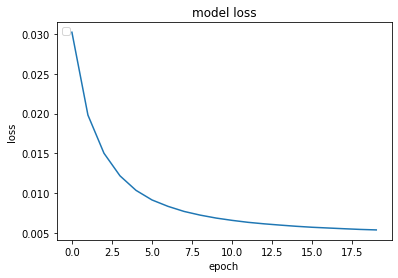

In [13]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [14]:
# Predict new Matrix Interactions
# set score zero on visualized games
# because we only want to predict the scores of those games that users do not have interactions before
#f(x)

new_matrix = model.predict(X) * (X == 0)

In [15]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,0,1,2,3,4,5,6,7,8,9,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,-0.005282,-0.003038,0.014327,0.003590,-0.020386,-0.000124,0.005896,0.017478,-0.009800,-0.007115,...,0.006442,-0.004994,0.000425,-0.010520,-0.009501,0.001187,-0.015046,0.006047,-0.034342,-0.011054
1,-0.012986,-0.005657,0.012794,-0.006474,-0.005530,-0.002517,0.012180,0.002095,0.012720,-0.012980,...,0.025952,-0.008042,0.001629,0.015354,-0.003490,-0.018889,-0.011728,-0.002780,-0.019865,-0.007206
2,0.013191,-0.003937,0.030327,0.010717,-0.016156,0.018583,0.003322,-0.018614,-0.003867,0.004154,...,0.010475,0.016038,-0.001052,0.034317,-0.007960,0.010924,0.006202,0.003418,-0.020391,-0.004608
3,0.003858,0.005090,0.015135,-0.001061,0.001664,-0.001668,-0.003632,0.001284,0.001281,0.005163,...,-0.003159,0.000882,0.003343,0.000861,0.010109,-0.006138,-0.009505,-0.000824,-0.015955,-0.000165
4,0.002438,0.000769,0.010685,-0.001605,-0.000403,0.000502,-0.001296,-0.001185,-0.000530,-0.004060,...,0.001539,0.000626,0.002511,-0.002068,0.004287,-0.013742,-0.008567,-0.001029,-0.022735,-0.004014


In [16]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-0.71242344 1.1772587


### Let us check the recommendation results from certain users

1.  Given a user_id, we will recommend the topn games that this user may like

In [17]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for users
    arguments:
    1. user_id: id for the users
    2. interact_matrix: row is user_id, column is the content_id. the value is the score that the user prefer the game
    3. df_content: content_id and the side information for the games
    4. topn: how many games will be returned (ranked by the view in interact_matrix)
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                                'score': pred_scores})
    
    # sort is time consuming in real-life !!!
    # based on content_id, we get the information of the game
    # ranking based on the score
    df_rec      = df_scores.set_index('content_id') \
                           .join(df_content.set_index('content_id')) \
                           .sort_values('score', ascending=False) \
                           .head(topn)[['score', 'game']]              
                  
    
    return df_rec[df_rec.score > 0] #set a hard threshold, i.e., the score should be positive

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

In [18]:
# Games previously purchased by the user
# we pass the original users_items_matrix_df, i.e., the true user behavior
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2058,1.0,Half-Life 2 Episode Two
2059,1.0,Half-Life 2 Lost Coast
2057,1.0,Half-Life 2 Episode One


In [19]:
# Recommended User Non-interacted Games
# we pass the new_users_items_matrix_df, i.e., outputs from autoencoder
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
2056,0.234877,Half-Life 2 Deathmatch
978,0.223912,Counter-Strike Source
972,0.144365,Counter-Strike
2062,0.124034,Half-Life Deathmatch Source
975,0.122289,Counter-Strike Global Offensive
974,0.117356,Counter-Strike Condition Zero Deleted Scenes
2457,0.117309,Left 4 Dead 2
973,0.109872,Counter-Strike Condition Zero
1126,0.105229,Day of Defeat Source


Recommender for **user_id = 1319**. This user prefers games in the same line as the RPG or strategy

In [20]:
# Games previously viewed by the user
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
2661,1.0,Medieval II Total War
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4330,1.0,The Elder Scrolls V Skyrim - Dragonborn
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4328,1.0,The Elder Scrolls V Skyrim
1301,1.0,Divinity Original Sin Enhanced Edition


In [21]:
# Recommended User Games
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
3837,0.107775,Skyrim High Resolution Texture Pack
3793,0.101941,Sid Meier's Civilization V Brave New World
1667,0.096327,Fallout New Vegas
1668,0.087151,Fallout New Vegas Courier's Stash
3792,0.081304,Sid Meier's Civilization V
4861,0.073975,Warframe
4632,0.061319,Total War SHOGUN 2 - Fall of the Samurai
4875,0.060411,"Warhammer 40,000 Dawn of War II"
450,0.057883,Batman Arkham Asylum GOTY Edition


### Open Questions

1. **How to quantify the performances?**

Cross-validation. But [split testing](https://www.facebook.com/business/help/1738164643098669) is better

[Measures](https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093) can be:

* CTR:

Compute the average precision of all the queries, truncated at
ranking position k. If for a query, the ranking algorithm returns
    n (n is less than k) results, the precision value will be computed
    as #(relevant items retrieved) / k
    
* Coverage: 

Computes the coverage for a list of recommendations

* Personalization: 

Measures recommendation similarity across users.

2. **How to improve the model?**

A survey about deep learning based recommendation system could be found [here](https://arxiv.org/abs/1707.07435)

3. **Real-Time is important, regarding model update and model inference**

Two-levels ranking
